# Monte Carlo Radiative Transfer

Running this notebook requires https://github.com/JuliaLang/IJulia.jl which prerequisites:
- Python
- Pip
- Jupyter notebook
- Julia

All code is written by scratch, inspired by the repo https://github.com/unoebauer/mcrtreview-tools. All theory is summarized from "Monte Carlo Radiative Transfer" by Noebauer and Sim.
## Background

### Important Variables

- Specific Intensity $I_v$ or $I(\mathbf{x}, t, \nu)$
- $\mathbf{x}$ position in space
- $\mu$ propagation direction
- $t$ time
- $\nu$ frequency
- $\chi_a$ absorption coefficient
- $\chi_s$ scattering coefficient
- $\chi_t = \chi_a + \chi_s$ total extinction coefficient or opacity

The radiative transfer equation describes the propagation of light through a medium. Let us start by assuming the light propagates through empty space then

$$
\frac{dI_v}{ds} = 0
$$

where $I$ is the intensity of light and $s$ is the distance traveled. Let us add a radiation absorbing medium to the mix. The radiative transfer equation then becomes

$$
\frac{dI_v}{ds} = -\alpha_v I_v
$$

where $\alpha$ is the *fractioanl depletion coefficient* per path length. We can define the optical depth $\tau$ as

$$
d \tau_v = -\alpha_v ds
$$

and the radiative transfer equation becomes

$$
\frac{dI_v}{d\tau_v} = -I_v
$$

However radiation can also travel through a radiation emitting medium. The radiative transfer equation then becomes

$$
\frac{dI_v}{ds} = -\alpha_v I_v + j_v
$$

where $j$ is the *emission coefficient*. We can also define it in terms of the optical depth

$$
\frac{dI_v}{d\tau_v} = \frac{j_v}{\alpha_v} - I_v.
$$

We then define the source function as 

$$
S_v = \frac{j_v}{\alpha_v}
$$

and the radiative transfer equation becomes

$$
\frac{dI_v}{d\tau_v} = S_v - I_v.
$$

## MCRT 

We can simulate the radiative transfer equation using Monte Carlo methods. We leverage an abstraction called photon packets, or machine photons, where a number of photons are grouped together. The photons are described by their position, direction, frequency, energy and weight. Over the course of the simulation, each photon packet continously accumulates optical depth. Hence contrary to classical simulations, we do not integrate over time but over optical depth.



We treat interactions with the medium as discrete interaction events, hence the MC algorithm needs to find when those events occur. We denote a random number as $\xi$. At the beginning of each packet trajectory event, each packet is assigned a new optical depth distance to the next interaction by

$$
\tau = -\log(\xi)
$$

we then compute the length of the path in physical space by dividing the optical depth by the total extinction coefficient $\chi_a$

$$
l = \frac{\tau}{\chi_a}
$$

or if we include scattering

$$
l = \frac{\tau}{\chi_t}.
$$

We can then update the position of the photon packet by

$$
\mathbf{x} = \mathbf{x} + l \mathbf{\mu}
$$

where $\mathbf{\mu}$ is the direction of the photon packet. For the case of pure absorption, the packet is absorbed and the simulation ends. If we include scattering, we need to determine if the photon packet is scattered which happens when

$$
\xi \leq \frac{\chi_s}{\chi_t}
$$

where $\xi$ is a random number between 0 and 1. If the photon packet is scattered, we need to draw a new direction for the photon packet

$$
\mathbf{\mu} = \xi - 1.
$$

## Julia implementation

Let us now implement the above with Julia

In [1]:
using Plots
using LaTeXStrings

First we create a new data structure which stores the Photon Packets data. 

In [2]:
# We define the Photon Packets
mutable struct PP
    # position in optical depth space
    x::AbstractArray{Float64, 1}
    # propagation direction, lengthless
    mu::AbstractArray{Float64, 1}
    # state of the packet, False means the photon has escaped
    absorbed::AbstractArray{Bool, 1}
    escaped::AbstractArray{Bool, 1}
end

In [3]:
function rand_range(type::Type{T}, N::Int, a::T, b::T)::AbstractArray{T, 1} where T
    return rand(type, N) .* (b .- a) .+ a
end

rand_range (generic function with 1 method)

We then code the event function, which is responsible to update the states of all photon packets at any moment in time. The tricky part is to care of the case, where a specific density function is provided. In this case the accumulated optical depth varies according the photons position in sphere, and needs to integrated accordingly. 

In [4]:
mutable struct Params
    # scattering coefficient
    chi_scattering::Float64
    # absorbtion coefficient
    chi_absorbtion::Float64
    # radius of the sphere in m
    radius::Float64
    # mass absorption coefficient
    kappa::Float64
    # number of packets
    N::Int
    # enable scattering -> Drawing new directions
    enable_scattering::Bool
    # sampling function for initial positions
    initial_sampling::Function
    # density function
    density::Union{Function, Nothing}
    # tracer steps 
    tracer_steps::Union{Int, Nothing}
end

In [77]:
function event!(pp::PP, params::Params)::Nothing

    N = size(pp.x)[1]

    # sample optical depth to next event
    tau_to_next = -log.(rand(Float64, N))

    # set chi total / opacity 
    chi_tot = params.chi_absorbtion
    if params.enable_scattering
        chi_tot += params.chi_scattering
    end
    
    if params.density == nothing
        # If the density is uniform, we can directly calculate the distance
        l_to_next = tau_to_next ./ chi_tot
        pp.x = sqrt.(pp.x.^2 .+ l_to_next.^2 .+ 2 .* pp.x .* l_to_next .* pp.mu)
    else
        tau_per_step = tau_to_next / params.tracer_steps

        for i in 1:params.tracer_steps  
            rho = params.density(pp.x)
            chi = params.kappa * rho

            l = tau_per_step ./ chi

            pp.x = sqrt.(pp.x.^2 .+ l.^2 .+ 2 .* pp.x .* l .* pp.mu)
            
        end
    end

    if params.density != nothing
        rho = params.density(pp.x)
        chi_tot = params.kappa * rho
    end

    # Decide if packets crossed boundaries
    escaped = pp.escaped .|| (pp.x .> params.radius) .|| (pp.x .< -params.radius)

    # Update the escape state of the packets
    pp.escaped = pp.escaped .|| (escaped .&& .!pp.absorbed)

    # Decide if packets are scattered or absorbed 
    if params.enable_scattering
        is_scattered = rand(N) .< (params.chi_scattering / chi_tot)
        # Update the scatter state of the packets
        pp.absorbed = pp.absorbed .|| (.!is_scattered .&& .!pp.escaped)
        # Scatter the packets -> Draw new propagation directions            
        pp.mu = rand_range(Float64, N, -1.0, 1.0)
    else
        # in the absorbtion only case, all packets which do not escape are absorbed
        # code in if scope would behave the same way
        pp.absorbed = .!pp.escaped
    end

    return nothing
end

event! (generic function with 1 method)

Now we implement the entire MRCT simulation. 

In [78]:
function mcrt!(
        packets :: PP,
        params :: Params) :: Nothing

    while !all((packets.absorbed .|| packets.escaped))
        event!(packets, params)
    end

    return nothing
end

mcrt! (generic function with 1 method)

## Sampling from density profile B

We are given the function 
$$
f(r) = \frac{1}{(r + \delta)^2}.
$$
To sample from the function we to find the inverse of the Integral. Hence we start with the integral
$$
F(r) = -\frac{1}{r + \delta}
$$
then we invert the function and get
$$
F^{-1} = \delta \frac{1}{r}.
$$
We can now plug in a random distribution as $r$ to sample from the density profile function $f(r)$. We can verify this visually:

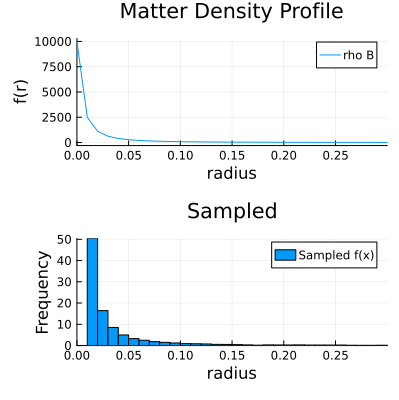

In [79]:
delta = 0.01
profile_A = x -> x
profile_B = x -> 1 ./ (x .+ delta).^2
sample_B = x -> delta .* 1 ./ x
sample_A = x -> x

x = 0:0.01:1
y = profile_B(x)

# two plots with shared x-axis
p1 = plot(x, y, label="rho B", xlabel="radius", ylabel="f(r)", title="Matter Density Profile", xlim=(0, 0.3))

x = rand(Float64, 10000)
y = sample_B(x)

bins = 0:0.01:1
p2 = histogram(y, label="Sampled f(x)", xlabel="radius", ylabel="Frequency", title="Sampled", xlim=(0, 0.3), normalize=:pdf, bins=bins)

plot(p1, p2, layout=(2, 1), legend=true, size=(400, 400))

## Sampling from a Sphere

In [80]:
function sample_from_sphere(radius::Float64, N::Int64)::AbstractArray{Float64, 1}
    # Same formula if oparating in optical depth or physical space
    sample = rand_range(Float64, N, -1.0, 1.0)
    uniform_radius = radius .* abs.(sample).^(1. ./ 3.) .* sign.(sample)

    return uniform_radius
end

sample_from_sphere (generic function with 1 method)

Lets test the sampling. Note that we except a sparser density of points in the central area in the case of the uniform sampling A. This is due to the 2d projection.

In [81]:
function plot_x(x::AbstractArray{Float64, 1})::Plots.Plot
    N = size(x)[1]
    angle = rand_range(Float64, N, 0.0, 2.0 * pi)

    return plot(
        x .* cos.(angle), 
        x .* sin.(angle), 
        seriestype = :scatter, 
        aspect_ratio = 1, 
        xlim=(-1.1, 1.1),
        ylim=(-1.1, 1.1),
        markersize = 1,
        markershape = :circle,
        markercolor = :black,
        markerstrokewidth = 0,
        label = "Packet Position")
end

plot_x (generic function with 1 method)

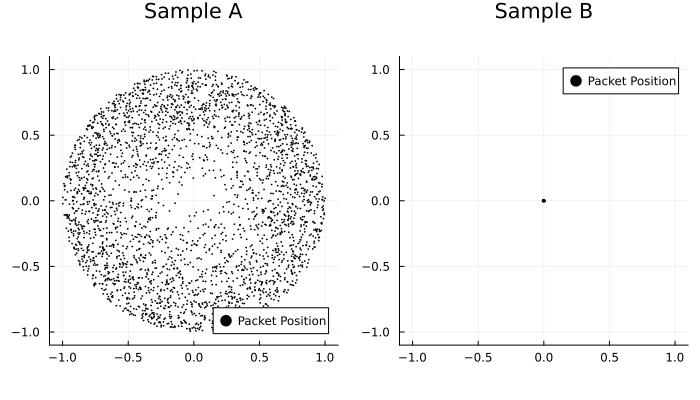

In [82]:
delta = 0.001

N = 3000
x = sample_from_sphere(1.0, N)
x = sample_A(x)

p1 = plot_x(x)
# set title and labels
title!("Sample A")

x = sample_B(x)

p2 = plot_x(x)

title!("Sample B")

plot(p1, p2, layout=(1, 2), legend=true, size=(700, 400))



With this working, we implement a function to initialize all photon packets.

In [83]:
function init_packets(params::Params)::PP
    return PP(
        # sample position from the density profile
        # params.density(sample_from_sphere(params.radius, params.N)),
        params.initial_sampling(sample_from_sphere(params.radius, params.N)),
        # initial velocity is randomly distributed between -1 and 1. 
        # Note that we could in principle leverage the sphere symmetry
        rand_range(Float64, params.N, -1.0, 1.0),
        # all packets start as not absorbed and not escaped
        zeros(Bool, params.N),
        zeros(Bool, params.N))
end

init_packets (generic function with 1 method)

In [84]:
function init_run_mcrt(params :: Params) :: PP

    packets = init_packets(params)
    mcrt!(packets, params)
    return packets
    
end

init_run_mcrt (generic function with 1 method)

Let us examine the mcrt process visually.

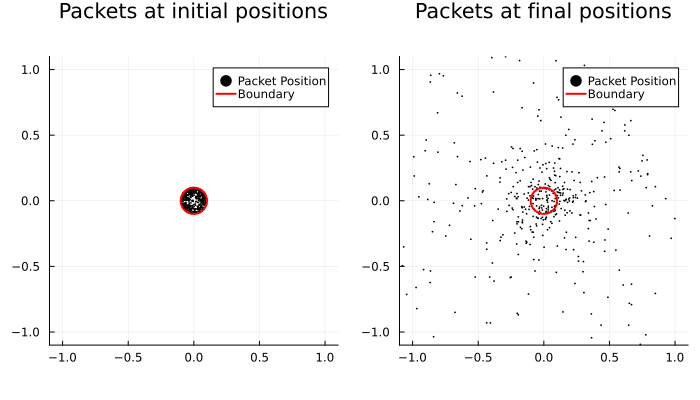

In [85]:
boundary_radius = 0.1
kappa = 1.0
params = Params(0.0, 1.0, boundary_radius, kappa, 500, false, sample_A, profile_A, 32)

packets = init_packets(params)

p1 = plot_x(packets.x)
# add cirlce to plot
x = cos.(0:0.01:2*pi) .* boundary_radius
y = sin.(0:0.01:2*pi) .* boundary_radius
plot!(x, y, color=:black, linewidth=2, label="Boundary", linecolor=:red)
# set title and labels
title!("Packets at initial positions")

mcrt!(packets, params)

p2 = plot_x(packets.x)
plot!(x, y, color=:black, linewidth=2, label="Boundary", linecolor=:red)
title!("Packets at final positions")

plot(p1, p2, layout=(1, 2), legend=true, size=(700, 400))


## Task 1: Escape probability

Escape probability without scattering. First we include the analytic solution from the reference implemenation.

In [86]:
function p_esc_analytic(t::Float64)::Float64
    """Calculate the escape probability analytically

    Note: it is assumed that there is no scattering within the sphere, but
    that photons/packets can only be absorbed.

    """
    return (3. / (4. * t) * (1. - 1. / (2. * t^2) + (1. / t + 1. / (2. * t^2)) * exp(-2. * t)))

end

p_esc_analytic (generic function with 1 method)

In [96]:
resolution = 20
n_packets = 20000

# J m^-3 K^-4, source: https://scienceworld.wolfram.com/physics/RadiationConstant.html
radiation_constant :: Float64 = 7.5657e-16
kappa = 1.0
# this parameter is irrelevant in the non scatterint case
chi_absorbtion = 1.0

esc_prob_A = zeros(resolution)
esc_prob_B = zeros(resolution)
esc_prob_analytic = zeros(resolution)

optical_depth = 10.0.^LinRange(-2, 2, resolution)

params = Params(
    0,  # scattering
    chi_absorbtion,
    0, # radius
    kappa,
    n_packets,
    false,
    profile_A,
    nothing,
    32)

for i in 1:resolution
    
    params.radius = optical_depth[i] / chi_absorbtion
    params.density = nothing
    
    packets_A = init_run_mcrt(params)
    esc_prob_A[i] = sum(packets_A.escaped) / n_packets

    params.density = profile_B
    packets_B = init_run_mcrt(params)
    esc_prob_B[i] = sum(packets_B.escaped) / n_packets

    esc_prob_analytic[i] = p_esc_analytic(optical_depth[i])
end


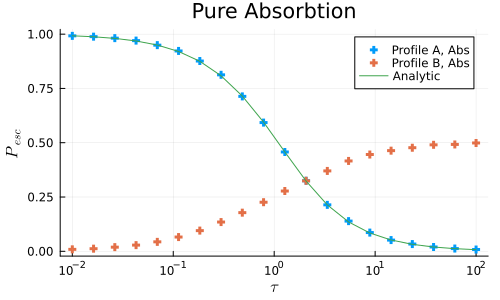

In [97]:
# x axis in log
plot(
    optical_depth, 
    esc_prob_A, 
    xaxis=:log, 
    label="Profile A, Abs", 
    seriestype=:scatter,
    markershape=:cross,
    markerstrokewidth=5,
    size=(500, 300))
plot!(optical_depth, 
    esc_prob_B, 
    xaxis=:log, 
    label="Profile B, Abs", 
    seriestype=:scatter, 
    markershape=:cross,
    markerstrokewidth=5)
plot!(optical_depth, 
    esc_prob_analytic, 
    xaxis=:log, 
    label="Analytic",
    seriestype=:line)
# add x and y labels
xlabel!(L"$\tau$")
ylabel!(L"$P_{esc}$")
# add title 
title!("Pure Absorbtion")

The escape probability for distribution B is lower. This is expected as the photon packets have a higher density in the center. 

## Task 2: Energy Flux

One part of the task is to find the energy flux of the sphere, as a function of optical depth. First we need to know the total amount of energy which is stored across the photon packets. 
 

In [98]:
function total_energy(radius::Float64, T::Float64, C::Float64)::Float64
    volume = 4/3 * pi * radius^3.0
    return C .* T.^4.0 .* volume
end

total_energy (generic function with 1 method)

In [99]:
resolution = 20

# J m^-3 K^-4, source: https://scienceworld.wolfram.com/physics/RadiationConstant.html
radiation_constant :: Float64 = 7.5657e-16

chi_absorbtion = 0.1
temperature = 10000.0

energy_flux_A = zeros(resolution)
energy_flux_B = zeros(resolution)
esc_prob_analytic = zeros(resolution)

optical_depth = 10.0.^LinRange(-2, 2, resolution)

params = Params(
    0,  # scattering
    chi_absorbtion,
    0, # radius
    kappa,
    n_packets,
    false,
    profile_A,
    nothing,
    32)

for i in 1:resolution

    params.radius = optical_depth[i] / chi_absorbtion
    params.density = sample_A

    surface_area = 4 * pi * params.radius^2
    energy = total_energy(params.radius, temperature, radiation_constant)
    
    packets = init_run_mcrt(params)
    esc_prob = sum(packets.escaped) / n_packets
    energy_flux_A[i] = energy * esc_prob / surface_area

    params.density = profile_B

    packets = init_run_mcrt(params)
    esc_prob = sum(packets.escaped) / n_packets
    energy_flux_B[i] = energy * esc_prob / surface_area

end

energy_flux_A .+= 0.001
energy_flux_B .+= 0.001


20-element Vector{Float64}:
    0.0167492655
    0.03801882312938271
    0.0826210155410118
    0.1760748496391981
    0.3789913672538489
    0.7481469324339473
    1.4772254113519403
    2.7470923073328097
    4.921972332844093
    8.72085366162451
   15.011697977783344
   24.902056307314894
   40.58303571342963
   67.05287663659789
  111.9836313691012
  182.72456056974374
  291.4018569792826
  474.51000329749985
  769.3328513874889
 1259.3117649999997

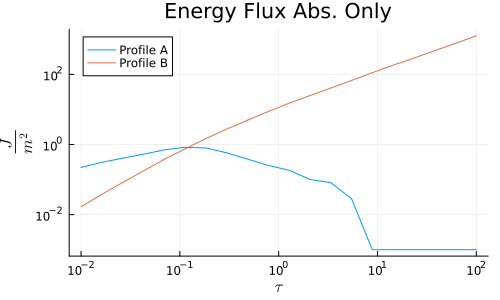

In [100]:
# x axis in log
plot(optical_depth, energy_flux_A, xaxis=:log, yaxis=:log, label="Profile A", size=(500, 300))
plot!(optical_depth, energy_flux_B, xaxis=:log, yaxis=:log, label="Profile B")
# set legend position
plot!(legend=:topleft)
# add x and y labels
xlabel!(L"$\tau$")
# y label J m^-2 s^-1
ylabel!(L"$\frac{J}{m^2}$")
# add title
title!("Energy Flux Abs. Only")

## Task 1 with scattering

In [101]:
resolution = 15

# J m^-3 K^-4, source: https://scienceworld.wolfram.com/physics/RadiationConstant.html
radiation_constant :: Float64 = 7.5657e-16

n_values = 3
albedos = LinRange(0.1, 1.5, n_values)
chi_absorbtion = 0.3

esc_prob_A = zeros((resolution, n_values))
esc_prob_B = zeros((resolution, n_values))

optical_depth = 10.0.^LinRange(-2, 2, resolution)

params = Params(
    0,  # scattering
    chi_absorbtion,
    0, # radius
    kappa,
    n_packets,
    false,
    sample_A,
    nothing,
    32)

for i in 1:resolution
    for j in 1:n_values
        chi_scattering = chi_absorbtion * (1.0 - albedos[j])
        params.chi_absorbtion = chi_absorbtion
        params.chi_scattering = chi_scattering
        params.radius = optical_depth[i] / (chi_absorbtion + chi_scattering)
        params.density = profile_A
        
        packets_A = init_run_mcrt(params)
        esc_prob_A[i, j] = sum(packets_A.escaped) / n_packets

        params.density = profile_B
        packets_B = init_run_mcrt(params)
        esc_prob_B[i, j] = sum(packets_B.escaped) / n_packets
    end
end

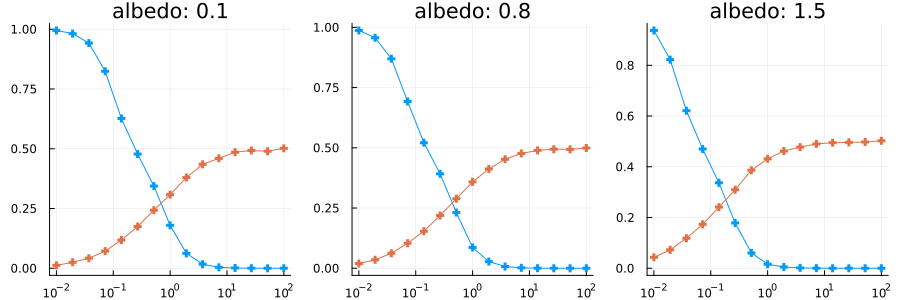

In [102]:
plots = []

for i in 1:n_values
    p = plot(
        optical_depth, 
        esc_prob_A[:, i], 
        xaxis=:log, 
        label="Profile A", 
        seriestype=:line,
        markershape=:cross,
        markerstrokewidth=5,
        size=(500, 300))
    plot!(optical_depth, 
        esc_prob_B[:, i], 
        xaxis=:log, 
        label="Profile B", 
        seriestype=:line, 
        markershape=:cross,
        markerstrokewidth=5)

    plot!(legend=:topleft)
    chi_scattering = chi_absorbtion * (1.0 - albedos[i])

    title!("albedo: $(albedos[i])")
    
    push!(plots, p)
end

# plot array of plots

plot(plots..., layout=(1, n_values), legend=false, size=(900, 300))

## Task 2 with scattering

In [103]:
resolution = 15

# J m^-3 K^-4, source: https://scienceworld.wolfram.com/physics/RadiationConstant.html
radiation_constant :: Float64 = 7.5657e-16

n_values = 3
albedos = LinRange(0.1, 1.5, n_values)
chi_absorbtion = 0.3

energy_A = zeros((resolution, n_values))
energy_B = zeros((resolution, n_values))

optical_depth = 10.0.^LinRange(-2, 2, resolution)

params = Params(
    0,  # scattering
    chi_absorbtion,
    0, # radius
    kappa,
    n_packets,
    false,
    sample_A,
    nothing,
    32)

for i in 1:resolution
    for j in 1:n_values
        energy = total_energy(optical_depth[i], temperature, radiation_constant)
        chi_scattering = chi_absorbtion * (1.0 - albedos[j])
        params.chi_absorbtion = chi_absorbtion
        params.chi_scattering = chi_scattering
        params.radius = optical_depth[i] / (chi_absorbtion + chi_scattering)
        params.density = profile_A
        
        packets_A = init_run_mcrt(params)
        esc_prob = sum(packets_A.escaped) / n_packets
        energy_A[i, j] = energy * esc_prob

        params.density = profile_B
        packets_B = init_run_mcrt(params)
        esc_prob = sum(packets_B.escaped) / n_packets
        energy_B[i, j] = energy * esc_prob
    end
end

energy_A .+= 0.001  
energy_B .+= 0.001

15×3 Matrix{Float64}:
     0.00100046      0.00100065      0.00100133
     0.00100593      0.00100807      0.00101681
     0.00106845      0.00110284      0.00119311
     0.00183519      0.00220081      0.0030868
     0.0108663       0.014182        0.0218718
     0.105934        0.137414        0.191013
     1.08579         1.27228         1.69369
     9.79673        11.2434         13.4745
    86.9552         94.0027        104.7
   711.973         743.078         795.686
  5396.85         5592.94         5812.67
 40889.2         41373.8         42474.8
     3.00729e5       3.02136e5       3.03391e5
     2.21516e6       2.18896e6       2.20438e6
     1.58329e7       1.60056e7       1.56427e7

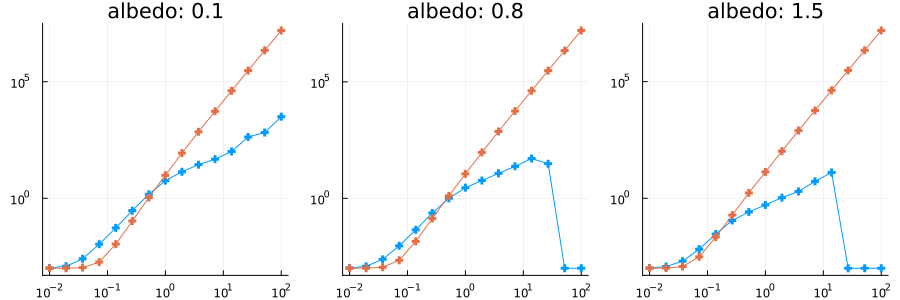

In [104]:
plots = []

for i in 1:n_values
    p = plot(
        optical_depth, 
        energy_A[:, i], 
        xaxis=:log, 
        yaxis=:log,
        label="Profile A", 
        seriestype=:line,
        markershape=:cross,
        markerstrokewidth=5,
        size=(500, 300))
    plot!(optical_depth, 
        energy_B[:, i], 
        xaxis=:log, 
        yaxis=:log,
        label="Profile B", 
        seriestype=:line, 
        markershape=:cross,
        markerstrokewidth=5)

    plot!(legend=:topleft)
    chi_scattering = chi_absorbtion * (1.0 - albedos[i])

    title!("albedo: $(albedos[i])")
    
    push!(plots, p)
end

# plot array of plots

plot(plots..., layout=(1, n_values), legend=false, size=(900, 300))